In [55]:
using Pkg
using Statistics
using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Aes
using Jlsca.Align
using Printf

using Plots
pyplot()
#plot() # does this ploit show something?


Plots.PyPlotBackend()

In [56]:
#trs=InspectorTrace("nano.trs")
trs=InspectorTrace("/home/albert/devel/scaCheapier/acq/fast-all.trs")
knownkey = hex2bytes("b0b0cee5cafebeef3031323334353637")

# normalize, this removes the really low (50hz?) frequencies
addSamplePass(trs, x -> (x .- mean(x)) ./ std(x))

[x] Skipping unknown tag 73 with length 1
[x] Skipping unknown tag 74 with length 1
[x] Skipping unknown tag 75 with length 4
[x] Skipping unknown tag 76 with length 4
Opened /home/albert/devel/scaCheapier/acq/fast-all.trs, #traces 100000, #samples 1250 (Float32), #data 32


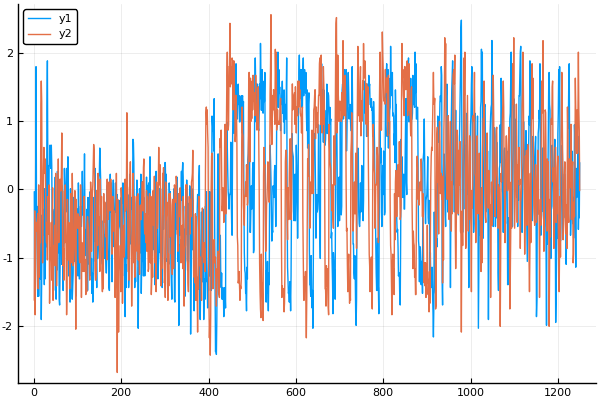

In [57]:
plot(getSamples(trs,3))
plot!(getSamples(trs,99))

Traces left after align: 100000

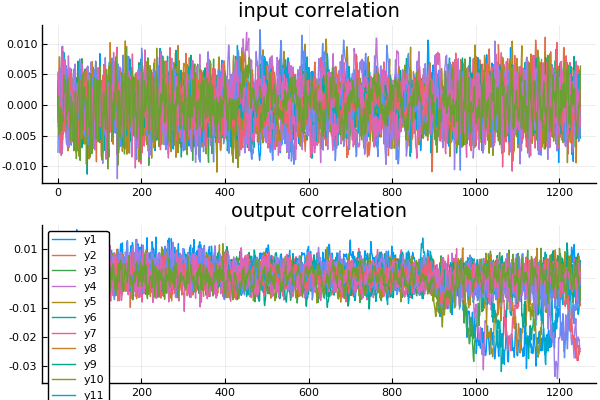

In [58]:
empty!(trs.meta.dataPasses)

# comment to correlate with data identity instead
addDataPass(trs, x -> hw.(x))

function correlateDataSamples(trs,len=length(trs))
    lenX = nrsamples(trs,true)
    lenY = length(getData(trs,1))
    ic = IncrementalCovarianceTiled(lenX,lenY)
    
    for t in 1:len
        data = getData(trs,t)
        samples = getSamples(trs,t)
        if length(data) == 0 || length(samples) == 0
            continue
        end
        add!(ic, samples, data)
    end    
    return getCorr(ic)
end

corsamplesdata = correlateDataSamples(trs)

# to leave the trs in consistent state
popDataPass(trs)

print("Traces left after align: $(length((findall(x -> x[2] > lowerBound, alignpass.shifts))))")

corinput = @view(corsamplesdata[:,1:16])
coroutput = @view(corsamplesdata[:,17:32])

p1=plot(corinput,leg=false,title="input correlation")
p2=plot(coroutput,title="output correlation")
plot(p1,p2,layout=(2,1))

# Alignment

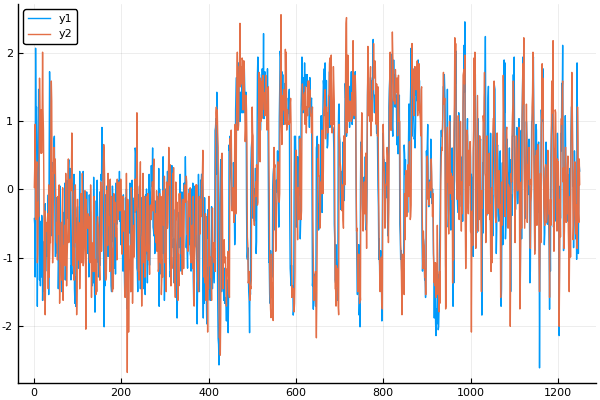

In [67]:
# clear the passes so we can run this cell out of order
empty!(trs.meta.passes)
empty!(trs.meta.dataPasses)

# to attack first round
# (referenceOffset,referenceSize) = (100,100)

# to attack last round
(referenceOffset,referenceSize) = (800,200)

(maxShift,lowerBound) = (100,0.5)
#(referenceOffset,referenceSize) = (250,750)
#(maxShift,lowerBound) = (50,0.80)

reference = getSamples(trs,1)[referenceOffset:referenceOffset+referenceSize]
c = CorrelationAlignFFT(reference, referenceOffset, maxShift)
alignpass = AlignPass(c, length(trs), lowerBound)

# normalize horizontally
addSamplePass(trs, x -> (x .- mean(x)) ./ std(x))

# aligment
addSamplePass(trs, alignpass)

# example of the results
plot(getSamples(trs,1))
plot!(getSamples(trs,99))

# Input-output correlation

Correlate the input and output data with the measurements

Traces left after align: 98672

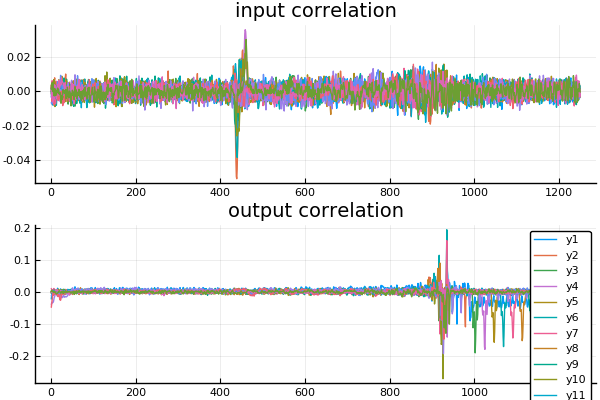

In [68]:
empty!(trs.meta.dataPasses)

# comment to correlate with data identity instead
addDataPass(trs, x -> hw.(x))

function correlateDataSamples(trs,len=length(trs))
    lenX = nrsamples(trs,true)
    lenY = length(getData(trs,1))
    ic = IncrementalCovarianceTiled(lenX,lenY)
    
    for t in 1:len
        data = getData(trs,t)
        samples = getSamples(trs,t)
        if length(data) == 0 || length(samples) == 0
            continue
        end
        add!(ic, samples, data)
    end    
    return getCorr(ic)
end

corsamplesdata = correlateDataSamples(trs)

# to leave the trs in consistent state
popDataPass(trs)

print("Traces left after align: $(length((findall(x -> x[2] > lowerBound, alignpass.shifts))))")

corinput = @view(corsamplesdata[:,1:16])
coroutput = @view(corsamplesdata[:,17:32])

p1=plot(corinput,leg=false,title="input correlation")
p2=plot(coroutput,title="output correlation")
plot(p1,p2,layout=(2,1))


# Sample selection for an attack

In [69]:
# Traditionally we would select a region to attack as the attack can be expensive. We just chose a faster attack
# only consider the selected samples for the attack
# addSamplePass(trs, x -> x[160:200])



# Attack 

In [70]:
# first define an attack
attack = AesSboxAttack()
attack.mode = CIPHER
attack.keyLength = KL128
attack.direction = FORWARD
# then an analysis
analysis = CPA()
analysis.leakages = [HW()] # [Bit(x) for x in 0:7]
# analysis.leakages =  [Bit(x) for x in 0:7]

# combine the two in a DpaAttack. The attack field is now also accessible
# through params.attack, same for params.analysis.
params = DpaAttack(attack,analysis)
params.dataOffset = attack.direction == FORWARD ? 1 : 17
params.knownKey = knownkey
params.updateInterval = div(length(trs),10)
# params.attack.xor = false # hd between sbox in/sbox out
# params.targetOffsets=[9]

setPostProcessor(trs, CondAvg())
rankData = sca(trs, params,1, length(trs))
# this so that we can do a readTraces on the same trs instance without fucking everything up 
setPostProcessor(trs, missing)


Jlsca running in Julia version: 1.0.1, 1 processes/1 workers/1 threads per worker

DPA parameters
attack:       AES Sbox CIPHER KL128 FORWARD
mode:         CIPHER
key length:   KL128
direction:    FORWARD
xor:          false
analysis:     CPA
leakages:     HW
maximization: abs global max
data at:      1
known key:    b0b0cee5cafebeef3031323334353637

phase: 1 / 1, #targets 16

Attacking columns 1:1250 out of 1250 columns (run 1 out of 1)
Running processor "Cond avg" on trace range 1:1:10000, 1 data passes, 2 sample passes


Processing traces 1:10000.. 100%|███████████████████████| Time: 0:00:03



Averaged 9859 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (246, 1250) (range 1:1250) and data shape (246,)
Results @ 246 rows, 1250 cols (9859 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, candidate: 0xba, peak: 0.271063 @ 352
rank:   2, candidate: 0x28, peak: 0.270018 @ 406
rank:   3, candidate: 0x25, peak: 0.266064 @ 1165
rank:   4, candidate: 0xb1, peak: 0.265753 @ 1215
rank: 151, correct  : 0xb0, peak: 0.203886 @ 292
recovered key material: ba
CPA on samples shape (251, 1250) (range 1:1250) and data shape (251,)
Results @ 251 rows, 1250 cols (9859 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.310745 @ 482
rank:   2, candidate: 0xf6, peak: 0.279262 @ 325
rank:   3, candidate: 0xb9, peak: 0.275296 @ 945
rank:   4, candidate: 0x90, peak: 0.266158 @ 98
rank:   5, candidate: 0x84, peak: 0.265567 @ 1150
recovered key material: b0
CPA on samples shape (252, 1250

Processing traces 10001:20000.. 100%|███████████████████| Time: 0:00:03



Averaged 19715 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (19715 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, candidate: 0x45, peak: 0.290873 @ 810
rank:   2, candidate: 0xf3, peak: 0.272359 @ 623
rank:   3, candidate: 0xea, peak: 0.270922 @ 243
rank:   4, candidate: 0x24, peak: 0.267474 @ 628
rank:  75, correct  : 0xb0, peak: 0.220444 @ 379
recovered key material: 45
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (19715 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.472457 @ 482
rank:   2, candidate: 0x79, peak: 0.316195 @ 800
rank:   3, candidate: 0xdf, peak: 0.300836 @ 206
rank:   4, candidate: 0xf6, peak: 0.279475 @ 325
rank:   5, candidate: 0xc3, peak: 0.271302 @ 201
recovered key material: b0
CPA on samples shape (255, 125

Processing traces 20001:30000.. 100%|███████████████████| Time: 0:00:03



Averaged 29600 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (29600 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, candidate: 0xbe, peak: 0.298790 @ 301
rank:   2, candidate: 0xfc, peak: 0.288395 @ 376
rank:   3, candidate: 0xf3, peak: 0.283510 @ 623
rank:   4, candidate: 0x95, peak: 0.274458 @ 371
rank:  43, correct  : 0xb0, peak: 0.231932 @ 379
recovered key material: be
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (29600 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.510502 @ 483
rank:   2, candidate: 0x5e, peak: 0.278867 @ 174
rank:   3, candidate: 0x79, peak: 0.278294 @ 800
rank:   4, candidate: 0x5b, peak: 0.276571 @ 659
rank:   5, candidate: 0xdf, peak: 0.271987 @ 206
recovered key material: b0
CPA on samples shape (255, 125

Processing traces 30001:40000.. 100%|███████████████████| Time: 0:00:03



Averaged 39447 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (39447 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, candidate: 0x3a, peak: 0.272672 @ 850
rank:   2, candidate: 0x09, peak: 0.271181 @ 672
rank:   3, candidate: 0xd6, peak: 0.270168 @ 643
rank:   4, candidate: 0xfe, peak: 0.268271 @ 954
rank:  51, correct  : 0xb0, peak: 0.227025 @ 379
recovered key material: 3a
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (39447 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.555140 @ 484
rank:   2, candidate: 0x24, peak: 0.273646 @ 926
rank:   3, candidate: 0x5f, peak: 0.271621 @ 1012
rank:   4, candidate: 0x40, peak: 0.267210 @ 326
rank:   5, candidate: 0xe7, peak: 0.265689 @ 1061
recovered key material: b0
CPA on samples shape (255, 1

Processing traces 40001:50000.. 100%|███████████████████| Time: 0:00:03



Averaged 49310 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (49310 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, candidate: 0x09, peak: 0.310121 @ 672
rank:   2, candidate: 0x06, peak: 0.309883 @ 803
rank:   3, candidate: 0xd1, peak: 0.309186 @ 1089
rank:   4, candidate: 0x50, peak: 0.282059 @ 998
rank:   9, correct  : 0xb0, peak: 0.261812 @ 466
recovered key material: 09
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (49310 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.570449 @ 484
rank:   2, candidate: 0x84, peak: 0.288880 @ 1150
rank:   3, candidate: 0xe0, peak: 0.281347 @ 388
rank:   4, candidate: 0x27, peak: 0.273386 @ 230
rank:   5, candidate: 0x35, peak: 0.272038 @ 450
recovered key material: b0
CPA on samples shape (255, 1

Processing traces 50001:60000.. 100%|███████████████████| Time: 0:00:03



Averaged 59187 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (59187 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, candidate: 0x06, peak: 0.299148 @ 803
rank:   2, candidate: 0x14, peak: 0.294476 @ 175
rank:   3, candidate: 0xd1, peak: 0.291279 @ 1089
rank:   4, candidate: 0xbe, peak: 0.279585 @ 421
rank:  10, correct  : 0xb0, peak: 0.268155 @ 466
recovered key material: 06
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (59187 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.609931 @ 483
rank:   2, candidate: 0x27, peak: 0.289898 @ 230
rank:   3, candidate: 0x84, peak: 0.282673 @ 1150
rank:   4, candidate: 0xdd, peak: 0.270839 @ 379
rank:   5, candidate: 0xe3, peak: 0.267435 @ 361
recovered key material: b0
CPA on samples shape (255, 1

Processing traces 60001:70000.. 100%|███████████████████| Time: 0:00:03



Averaged 69062 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (69062 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, candidate: 0x06, peak: 0.307199 @ 803
rank:   2, candidate: 0x66, peak: 0.294522 @ 732
rank:   3, candidate: 0x1b, peak: 0.293400 @ 602
rank:   4, candidate: 0xd1, peak: 0.285189 @ 1089
rank:   6, correct  : 0xb0, peak: 0.277276 @ 466
recovered key material: 06
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (69062 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.623120 @ 484
rank:   2, candidate: 0x27, peak: 0.302296 @ 230
rank:   3, candidate: 0xc2, peak: 0.301396 @ 567
rank:   4, candidate: 0x02, peak: 0.279943 @ 686
rank:   5, candidate: 0xed, peak: 0.275900 @ 897
recovered key material: b0
CPA on samples shape (255, 12

Processing traces 70001:80000.. 100%|███████████████████| Time: 0:00:03



Averaged 78945 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (78945 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, candidate: 0x66, peak: 0.299411 @ 732
rank:   2, candidate: 0x06, peak: 0.299142 @ 803
rank:   3, correct  : 0xb0, peak: 0.293591 @ 466
rank:   4, candidate: 0xbe, peak: 0.287421 @ 421
rank:   5, candidate: 0x5f, peak: 0.274910 @ 820
recovered key material: 66
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (78945 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.652008 @ 484
rank:   2, candidate: 0xc2, peak: 0.300230 @ 567
rank:   3, candidate: 0x27, peak: 0.291376 @ 230
rank:   4, candidate: 0x02, peak: 0.277997 @ 976
rank:   5, candidate: 0x38, peak: 0.276501 @ 65
recovered key material: b0
CPA on samples shape (255, 1250

Processing traces 80001:90000.. 100%|███████████████████| Time: 0:00:03



Averaged 88816 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (88816 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.350511 @ 466
rank:   2, candidate: 0x66, peak: 0.281813 @ 732
rank:   3, candidate: 0x20, peak: 0.280546 @ 88
rank:   4, candidate: 0x22, peak: 0.272664 @ 1238
rank:   5, candidate: 0x06, peak: 0.271707 @ 803
recovered key material: b0
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (88816 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.686331 @ 484
rank:   2, candidate: 0xc2, peak: 0.295918 @ 567
rank:   3, candidate: 0x38, peak: 0.273539 @ 65
rank:   4, candidate: 0x02, peak: 0.271148 @ 976
rank:   5, candidate: 0x48, peak: 0.263556 @ 926
recovered key material: b0
CPA on samples shape (255, 1250

Processing traces 90001:100000.. 100%|██████████████████| Time: 0:00:03



Averaged 98672 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (98672 rows consumed)
target: 1, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.342818 @ 466
rank:   2, candidate: 0xbe, peak: 0.279197 @ 421
rank:   3, candidate: 0x15, peak: 0.269374 @ 825
rank:   4, candidate: 0x31, peak: 0.268580 @ 1178
rank:   5, candidate: 0x20, peak: 0.268482 @ 88
recovered key material: b0
CPA on samples shape (255, 1250) (range 1:1250) and data shape (255,)
Results @ 255 rows, 1250 cols (98672 rows consumed)
target: 2, phase: 1, #candidates 256, "Sbox out"
rank:   1, correct  : 0xb0, peak: 0.703473 @ 483
rank:   2, candidate: 0x38, peak: 0.303924 @ 65
rank:   3, candidate: 0x27, peak: 0.288944 @ 230
rank:   4, candidate: 0x08, peak: 0.265574 @ 252
rank:   5, candidate: 0xb5, peak: 0.265028 @ 229
recovered key material: b0
CPA on samples shape (255, 1250

missing

Was the correct key recovered? Check the resulting key with data in the first trace: 

In [71]:
recoveredkey = getKey(params, rankData)
w = KeyExpansion(recoveredkey,10,4)
inputoutput = getData(trs,1)
@assert inputoutput[17:32] == Cipher(inputoutput[1:16], w)

AssertionError: AssertionError: inputoutput[17:32] == Cipher(inputoutput[1:16], w)

Evolution of the rank of the correct, known, key. You can't plot this when you set params.knownKey = missing

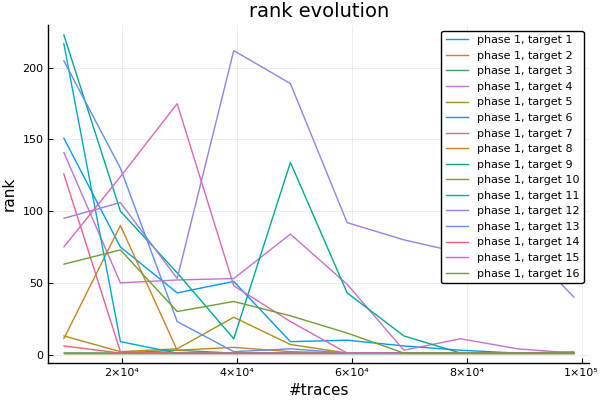

In [72]:
plot(PlotRanksEvolution(),rankData,params)

Evolution of the rank of the correct, known, key.

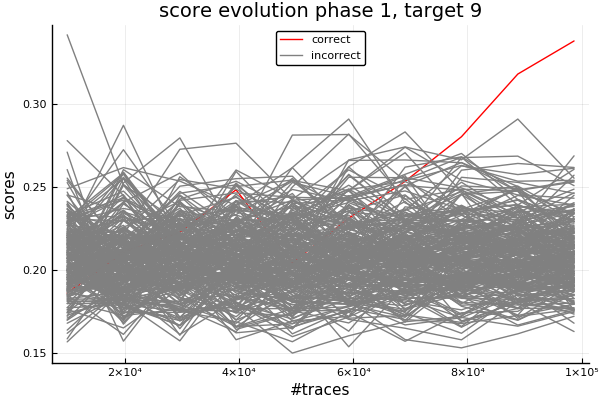

In [73]:
plot(PlotScoresEvolution(),rankData,params,1,9)

You actually can make this plot too when params.knownKey = missing; see how cool that is.

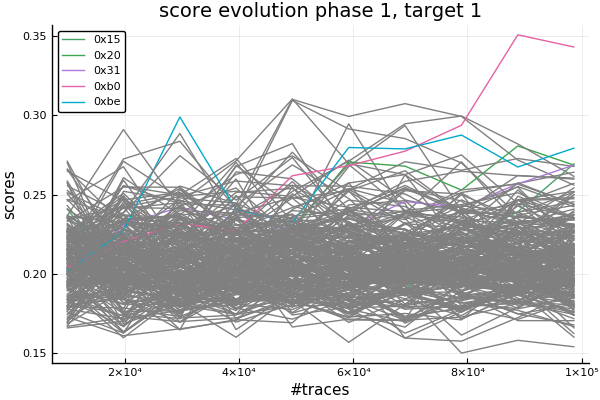

In [74]:
params.knownKey = missing
plot(PlotScoresEvolution(),rankData,params,1,1)